# Single image super-resolution with deep neural networks

This article is an introduction to single image super-resolution. It covers some important developments in recent years and shows their implementation in Tensorflow 2.0. The primary focus is on specialized residual network architectures and generative adversarial networks (GANs) for fine-tuning super-resolution models. 

Super-resolution is the process of recovering a high-resolution (HR) image from a low-resolution (LR) image. We will refer to a recovered HR image as *super-resolved image* or *SR image*. Super-resolution is an ill-posed problem since a large number of solutions exist for a single pixel in an LR image. Simple approaches like bilinear or bicubic interpolation use only local information in an LR image to compute pixel values in the corresponding SR image. 

Supervised machine learning approaches, on the other hand, learn mapping functions from LR images to HR images from a large number of examples. Super-resolution models are trained with LR images as input and HR images as target. The mapping function learned by these models is the inverse of a downgrade function that transforms HR images to LR images. Downgrade functions can be known or unknown. 

Known downgrade functions are used in image processing pipelines, for example, like bicubic downsampling. With known downgrade functions, LR images can be automatically obtained from HR images. This allows the creation of large training datasets from a vast amount of freely available HR images which enables [self-supervised learning](https://hackernoon.com/self-supervised-learning-gets-us-closer-to-autonomous-learning-be77e6c86b5a).

If the downgrade function is unknown, supervised model training requires existing LR and HR image pairs to be available which can be difficult to collect. Alternatively, unsupervised learning methods can be used that learn to approximate the downgrade function from unpaired LR and HR images. In this article though, we will use a known downgrade function (bicubic downsampling) and follow a supervised learning approach. 

A more detailed overview on single image super-resolution is given in [these](https://arxiv.org/abs/1902.06068) [papers](https://arxiv.org/abs/1904.07523). A higher-level training API for the example code in this article is implemented in [this repository](https://github.com/krasserm/super-resolution).

## High-level architecture

Many state-of-the-art super-resolution models learn most of the mapping function in LR space followed by one or more upsampling layers at the end of the network. This is called *post-upsampling SR* in Fig. 1. Upsampling layers are learnable and trained together with the preceding convolution layers in an end-to-end manner. 

![Fig. 1](docs/images/figure_1.png)
<center>Fig. 1. Upsampling layers positions.</center>

Earlier approaches first upsampled the LR image with a pre-defined upsampling operation and then learned the mapping in HR space (*pre-upsampling SR*). A disadvantage of this approach is that more parameters per layer are required which leads to higher computational costs and limits the construction of deeper neural networks. 

### Residual design

Super-resolution requires that most of the information contained in an LR image must be preserved in the SR image. Super-resolution models therefore mainly learn the residuals between LR and HR images. [Residual network designs](https://en.wikipedia.org/wiki/Residual_neural_network) are therefore of high importance: identity information is conveyed via skip connections whereas reconstruction of high frequency content is done on the main path of the network.

![Fig. 2](docs/images/figure_2.png)
<center>Fig. 2. Global skip connection.</center>

Fig. 2. shows a global skip connection over several layers. These layers are often residual blocks as in [ResNet](https://arxiv.org/abs/1512.03385) or specialized variants (see sections [EDSR](#edsr) and [WDSR](#wdsr)). Local skip connections in residual blocks make the network easier to optimize and therefore support the construction of deeper networks.

### Upsampling layer

The upsampling layer used in this article is a [sub-pixel convolution](https://arxiv.org/abs/1609.05158) layer. Given an input of size $H \times W \times C$ and an upsampling factor $s$, the sub-pixel convolution layer first creates a representation of size $H \times W \times s^2C$ via a convolution operation and then reshapes it to $sH \times sW \times C$, completing the upsampling operation. The result is an output spatially scaled by factor $s$.

![Fig. 3](docs/images/figure_3.png)
<center>Fig. 3. Sub-pixel convolution.</center>

An alternative are [transposed convolution](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d) layers. Transposed convolutions can be learned too but have the disadvantage that they have a smaller receptive field than sub-pixel convolutions and can therefore process less contextual information which often results in less accurate predictions.

## Super-resolution models

### EDSR

One super-resolution model that follows this high-level architecture is described in the paper [Enhanced Deep Residual Networks for Single Image Super-Resolution](https://arxiv.org/abs/1707.02921) (EDSR). It is a winner of the [NTIRE 2017](http://www.vision.ee.ethz.ch/ntire17/) super-resolution challenge. Here's an overview of the EDSR architecture:

![Fig. 4](docs/images/figure_4.png)
<center>Fig. 4. EDSR architecture.</center>

Its residual block design differs from that of ResNet. Batch normalization layers have been removed together with the final ReLU activation as shown on the right side of Fig. 5.  

![Fig. 5](docs/images/figure_5.png)
<center>Fig. 5. Residual block design in ResNet (left) and in EDSR (right).</center>

The EDSR authors argue that batch normalization loses scale information of images and reduces the range flexibility of activations. Removal of batch normalization layers not only increases super-resolution performance but also reduces GPU memory up to 40% so that significantly larger models can be trained.

EDSR uses a single sub-pixel upsampling layer for super-resolution scales (i.e. upsampling factors) $\times 2$ and $\times 3$ and two upsampling layers for scale $\times 4$. The following `edsr` function implements the EDSR model with Tensorflow 2.0. The default arguments correspond to the EDSR baseline described in the paper. Model training is described further below.


In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model

DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255


def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


def normalize(x):
    return (x - DIV2K_RGB_MEAN) / 127.5


def denormalize(x):
    return x * 127.5 + DIV2K_RGB_MEAN

### WDSR

Another super-resolution model is a derivative of EDSR and is described in the paper [Wide Activation for Efficient and Accurate Image Super-Resolution](https://arxiv.org/abs/1808.08718), a winner in the realistic tracks of the [NTIRE 2018](http://www.vision.ee.ethz.ch/ntire18/) super-resolution challenge. It makes further changes to the residual block design by reducing the number of channels on the identity mapping path and increasing the number of channels in each residual block without increasing the total number of parameters. The residual block design of their WDSR-A and WDSR-B models is shown in Fig. 6, a Tensorflow 2.0 implementation is available [here](https://github.com/krasserm/super-resolution/blob/master/model/wdsr.py).

![Fig. 6](docs/images/figure_6.png)
<center>Fig. 6. Residual block design in EDSR (left), WDSR-A (middle) and WDSR-B (right).</center>

The authors conjecture that increasing the number of channels before ReLU in residual blocks allows more information to pass through the activation function which further increases model performance. They also found that the implementation of [weight normalization](https://arxiv.org/abs/1602.07868) further eases training and convergence of deeper models so that they could use learning rates that are an order of magnitude higher compared to those used in EDSR training.

This is not surprising as the removal of weight normalization layers in EDSR makes it more difficult to train deeper models. Weight normalization is just a reparameterization of neural network weights that decouples the direction of weight vectors from their magnitude which improves the conditioning of the optimization problem and speeds up convergence. 

Data-dependent initialization of weight normalization layer parameters is not done though. It would rescale features similar to batch normalization which would decrease model performance as has been shown in the EDSR paper and confirmed in the WDSR paper. On the other hand, using weight normalization alone without data-dependent initialization leads to better accuracy of deeper WDSR models.

## Model training

If you want to skip running trained code in this section, you can download pre-trained models [here](https://drive.google.com/open?id=1wN4JxevxQ8muL3gCFEyrQMSTHSIUqgPS) and use in the [next section](#results) for generating SR images from LR images. 

### Data

For training EDSR and WDSR models we will use the [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/) dataset. It is a dataset of LR and HR image pairs with a large diversity of contents. LR images are available for different downgrade functions. We will use `bicubic` downsampling here. There are 800 training HR images and 100 validation HR images. 

For data augmentation, random crops, flips and rotations are made to get a large number of different training images. A `DIV2K` [data loader](https://github.com/krasserm/super-resolution/blob/master/README.md#div2k-dataset) automatically downloads DIV2K images for given scale and downgrade function and provides LR and HR image pairs as `tf.data.Dataset`.  

In [ ]:
from data import DIV2K

train = DIV2K(scale=4, downgrade='bicubic', subset='train')
train_ds = train.dataset(batch_size=16, random_transform=True)

### Pixel loss

The pixel-wise $L^2$ loss and the pixel-wise $L^1$ loss are frequently used loss functions for training super-resolution models. They measure the pixel-wise mean squared error and the pixel-wise mean absolute error, respectively, between an HR image $I^{HR}$ and an SR image $I^{SR}$:

$$
\begin{align*}
\mathcal{L}_{pixel, L^2}(I^{HR}, I^{SR}) &= {1 \over HWC} 
\lVert I^{HR} - I^{SR} \rVert_2^2
\tag{1} \\
\mathcal{L}_{pixel, L^1}(I^{HR}, I^{SR}) &= {1 \over HWC} 
\lVert I^{HR} - I^{SR} \rVert_1
\tag{2}
\end{align*}
$$

where $H$, $W$ and $C$ are the height, width and number of channels of the image, respectively. The pixel-wise $L^2$ loss directly optimizes [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio), an evaluation metric often used in super-resolution competitions. Experiments have shown that the pixel-wise $L^1$ loss can sometimes achieve even better performance and is therefore used for EDSR and WDSR training.

In [ ]:
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

# Create directory for saving model weights
weights_dir = 'weights/article'
os.makedirs(weights_dir, exist_ok=True)

# EDSR baseline as described in the EDSR paper (1.52M parameters)
model_edsr = edsr(scale=4, num_res_blocks=16)

# Adam optimizer with a scheduler that halfs learning rate after 200,000 steps
optim_edsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_edsr.compile(optimizer=optim_edsr, loss='mean_absolute_error')
model_edsr.fit(train_ds, epochs=300, steps_per_epoch=1000)

# Save model weights
model_edsr.save_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

In [ ]:
from model.wdsr import wdsr_b

# Custom WDSR B model (0.62M parameters)
model_wdsr = wdsr_b(scale=4, num_res_blocks=32)

# Adam optimizer with a scheduler that halfs learning rate after 200,000 steps
optim_wdsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-3, 5e-4]))

# Compile and train model for 300,000 steps with L1 pixel loss
model_wdsr.compile(optimizer=optim_wdsr, loss='mean_absolute_error')
model_wdsr.fit(train_ds, epochs=300, steps_per_epoch=1000)

# Save weights
model_wdsr.save_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))

A major problem with pixel-wise loss functions is that they lead to poor perceptual quality. Generated SR images often lack high-frequency content, realistic textures and are perceived blurry. This problem is addressed with perceptual loss functions.

### Perceptual loss

A milestone paper for generating SR images with better perceived quality is [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (SRGAN). The authors use a perceptual loss function composed of a *content loss* and an *adversarial loss*. The content loss compares deep features extracted from SR and HR images with a pre-trained [VGG network](https://arxiv.org/abs/1409.1556) $\phi$

$$
\mathcal{L}_{content}(I^{HR}, I^{SR}; \phi, l) = {1 \over H_l W_l C_l} 
\lVert \phi_l(I^{HR}) - \phi_l(I^{SR}) \rVert_2^2
\tag{3}
$$

were $\phi_l(I)$ is the feature map at layer $l$ and $H_l$, $W_l$ and $C_l$ are the height, width and number of channels of that feature map, respectively. They also train their super-resolution model as generator $G$ in a [generative adversarial network](https://arxiv.org/abs/1406.2661) (GAN). The GAN descriminator $D$ is optimized for descriminating SR from HR images whereas the generator is optimized for generating more realistic SR images in order to fool the discriminator. They combine the generator loss

$$
\mathcal{L}_{generator}(I^{LR}; G, D) = 
- \log D(G(I^{LR}))
\tag{4}
$$

with the content loss to a perceptual loss which is used as optimization target for super-resolution model training:

$$
\mathcal{L}_{perceptual} = \mathcal{L}_{content} + 10^{-3} \mathcal{L}_{generator}
\tag{5}
$$

Instead of training the super-resolution model i.e. the generator from scratch in a GAN, they pre-train it with a pixel-wise loss and fine-tune the model with a perceptual loss. The SRGAN paper uses *SRResNet* as super-resolution model, a predecessor of [EDSR](#edsr).

I found in experiments that the SRGAN approach also works very well for fine-tuning EDSR and WDSR models. The following example fine-tunes an EDSR baseline model that was pre-trained with a pixel-wise $L^1$ loss. The definition of the SRGAN discriminator is [here](https://github.com/krasserm/super-resolution/blob/f47a912d9540f2aa74d8c829ae8262b52776162e/model/srgan.py#L60).

In [ ]:
from model import srgan

# Used in content_loss
mean_squared_error = tf.keras.losses.MeanSquaredError()

# Used in generator_loss and discriminator_loss
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Model that computes the feature map after the 4th convolution 
# before the 5th max-pooling layer in VGG19. This is layer 20 in
# the corresponding Keras model.
vgg = srgan.vgg_54()

# EDSR model used as generator in SRGAN
generator = edsr(scale=4, num_res_blocks=16)
generator.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

# SRGAN discriminator
discriminator = srgan.discriminator()

# Optmizers for generator and discriminator. SRGAN will be trained for
# 200,000 steps and learning rate is reduced from 1e-4 to 1e-5 after
# 100,000 steps
schedule = PiecewiseConstantDecay(boundaries=[100000], values=[1e-4, 1e-5])
generator_optimizer = Adam(learning_rate=schedule)
discriminator_optimizer = Adam(learning_rate=schedule)

def generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

def discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

@tf.function
def content_loss(hr, sr):
    sr = tf.keras.applications.vgg19.preprocess_input(sr)
    hr = tf.keras.applications.vgg19.preprocess_input(hr)
    sr_features = vgg(sr) / 12.75
    hr_features = vgg(hr) / 12.75
    return mean_squared_error(hr_features, sr_features)

@tf.function
def train_step(lr, hr):
    """SRGAN training step.
    
    Takes an LR and an HR image batch as input and returns
    the computed perceptual loss and discriminator loss.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        # Forward pass
        sr = generator(lr, training=True)
        hr_output = discriminator(hr, training=True)
        sr_output = discriminator(sr, training=True)

        # Compute losses
        con_loss = content_loss(hr, sr)
        gen_loss = generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = discriminator_loss(hr_output, sr_output)

    # Compute gradient of perceptual loss w.r.t. generator weights 
    gradients_of_generator = gen_tape.gradient(perc_loss, generator.trainable_variables)
    # Compute gradient of discriminator loss w.r.t. discriminator weights 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update weights of generator and discriminator
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return perc_loss, disc_loss

pls_metric = tf.keras.metrics.Mean()
dls_metric = tf.keras.metrics.Mean()

steps = 200000
step = 0

# Train SRGAN for 200,000 steps.
for lr, hr in train_ds.take(steps):
    step += 1

    pl, dl = train_step(lr, hr)
    pls_metric(pl)
    dls_metric(dl)

    if step % 50 == 0:
        print(f'{step}/{steps}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
        pls_metric.reset_states()
        dls_metric.reset_states()
        
generator.save_weights(os.path.join(weights_dir, 'weights-edsr-16-x4-fine-tuned.h5'))

You can also use the WDSR-B model from the previous section as a drop-in replacement for EDSR by making the following changes in the above code:

In [ ]:
# WDSR B model used as generator in SRGAN
generator = wdsr_b(scale=4, num_res_blocks=32)
generator.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))
# Run SRGAN training ...
generator.save_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4-fine-tuned.h5'))

## Results

If you didn't run training code in the [previous section](#model-training), download model weights [here](https://drive.google.com/open?id=1wN4JxevxQ8muL3gCFEyrQMSTHSIUqgPS) and extract the downloaded archive. The trained EDSR model can now be used to create SR images from [LR images](https://github.com/krasserm/super-resolution/tree/master/demo). One can clearly see how fine-tuning with a perceptual loss creates more realistic textures in SR images compared to training with a pixel-wise loss alone.

In [2]:
import os
import matplotlib.pyplot as plt

from model import resolve_single
from utils import load_image

%matplotlib inline

def resolve_and_plot(model_pre_trained, model_fine_tuned, lr_image_path):
    lr = load_image(lr_image_path)
    
    sr_pt = resolve_single(model_pre_trained, lr)
    sr_ft = resolve_single(model_fine_tuned, lr)
    
    plt.figure(figsize=(20, 20))
    
    model_name = model_pre_trained.name.upper()
    images = [lr, sr_pt, sr_ft]
    titles = ['LR', f'SR ({model_name}, pixel loss)', f'SR ({model_name}, perceptual loss)']
    positions = [1, 3, 4]
    
    for i, (image, title, position) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, position)
        plt.imshow(image)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
        
weights_dir = 'weights/article'

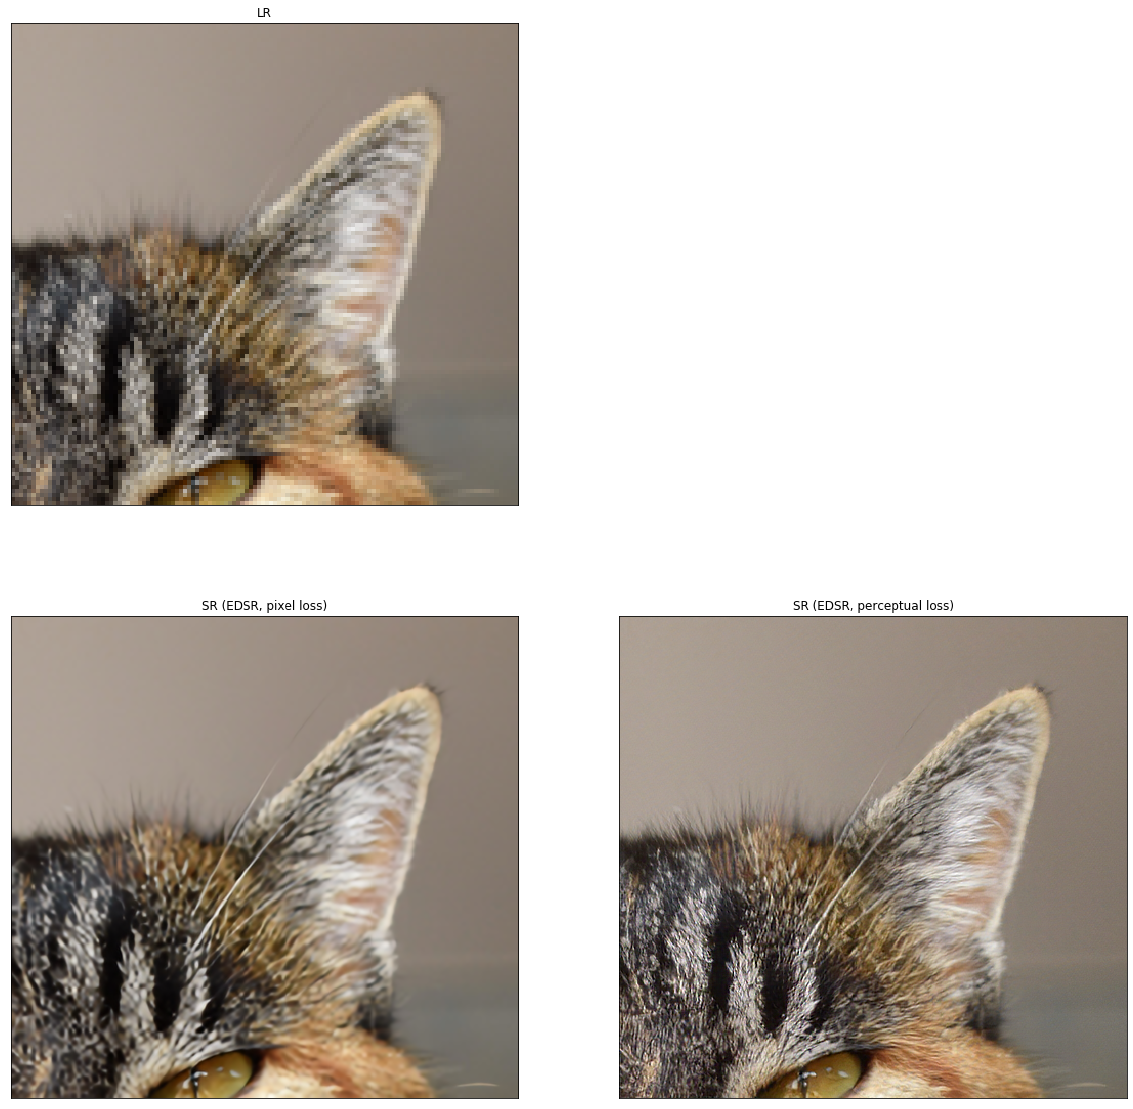

In [3]:
edsr_pre_trained = edsr(scale=4, num_res_blocks=16)
edsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4.h5'))

edsr_fine_tuned = edsr(scale=4, num_res_blocks=16)
edsr_fine_tuned.load_weights(os.path.join(weights_dir, 'weights-edsr-16-x4-fine-tuned.h5'))

resolve_and_plot(edsr_pre_trained, edsr_fine_tuned, 'demo/0869x4-crop.png')

Also the fine-tuned WDSR-B model produces SR images with more realistic textures. 

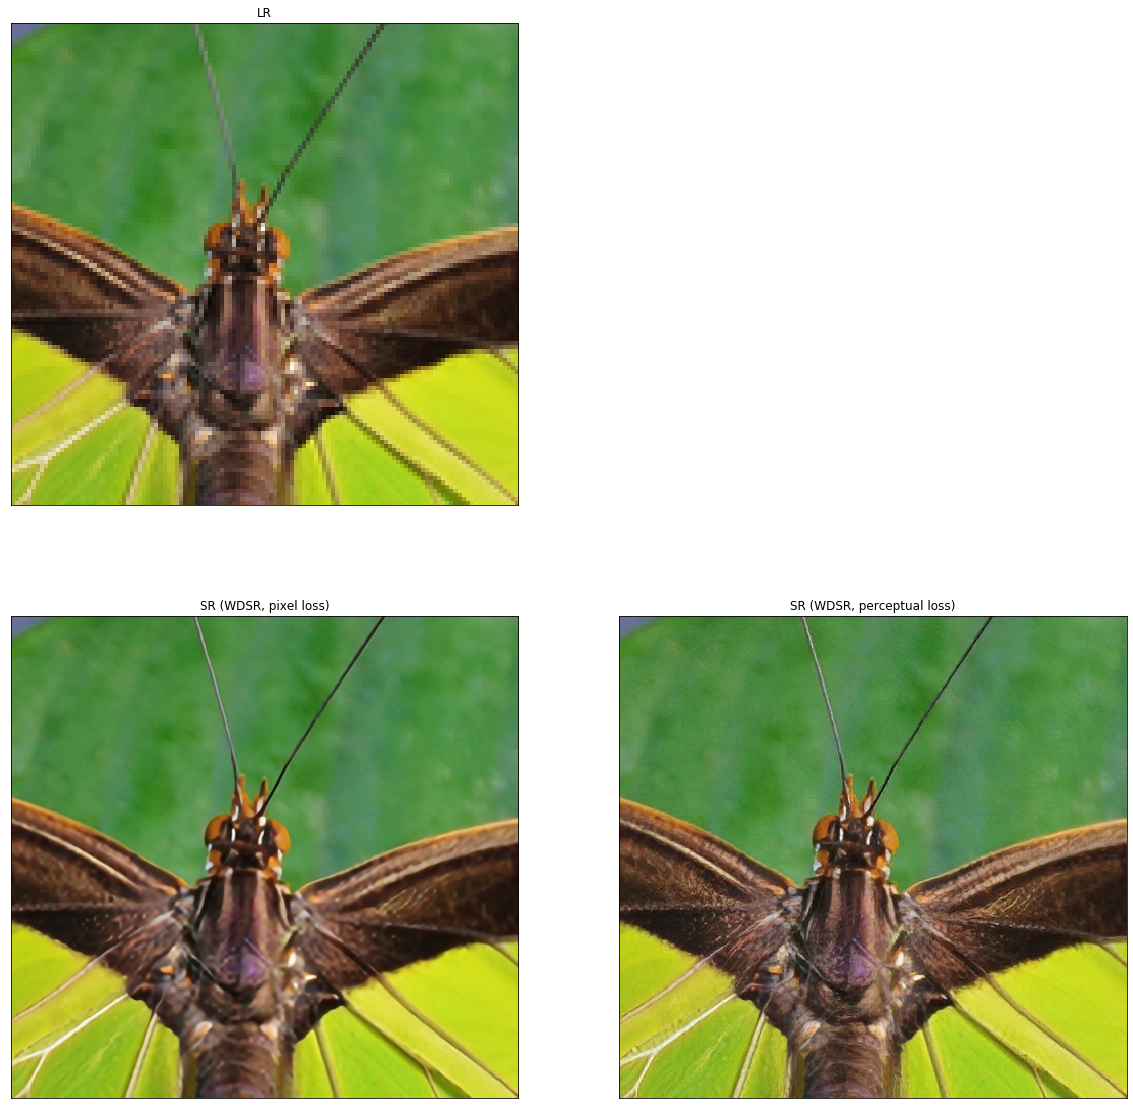

In [5]:
from model.wdsr import wdsr_b

wdsr_pre_trained = wdsr_b(scale=4, num_res_blocks=32)
wdsr_pre_trained.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4.h5'))

wdsr_fine_tuned = wdsr_b(scale=4, num_res_blocks=32)
wdsr_fine_tuned.load_weights(os.path.join(weights_dir, 'weights-wdsr-b-32-x4-fine-tuned.h5'))

resolve_and_plot(wdsr_pre_trained, wdsr_fine_tuned, 'demo/0829x4-crop.png')